<a href="https://colab.research.google.com/github/Trung0Minh/AIO2023-MODULE-6/blob/main/cnn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip ./drive/MyDrive/img_cls_weather_dataset.zip -d ./weather-dataset

In [2]:
!mv ./weather-dataset/weather-dataset/dataset ./dataset

In [3]:
!rm -rf ./weather-dataset

In [4]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
root_dir = 'dataset/'
classes = {label_idx: class_name for label_idx, class_name in enumerate(os.listdir(root_dir))}
classes

{0: 'rain',
 1: 'dew',
 2: 'snow',
 3: 'rainbow',
 4: 'lightning',
 5: 'glaze',
 6: 'frost',
 7: 'rime',
 8: 'sandstorm',
 9: 'fogsmog',
 10: 'hail'}

In [6]:
img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

In [7]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(img_paths, labels,
                                                    test_size=val_size,
                                                    shuffle=is_shuffle,
                                                    random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=test_size,
                                                    shuffle=is_shuffle,
                                                    random_state=seed)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

array([[[ 61,  72,  76],
        [ 63,  74,  78],
        [ 66,  77,  81],
        ...,
        [239, 253, 240],
        [241, 255, 242],
        [243, 255, 244]],

       [[ 62,  73,  77],
        [ 65,  76,  80],
        [ 67,  78,  82],
        ...,
        [239, 253, 240],
        [240, 253, 243],
        [242, 255, 243]],

       [[ 61,  72,  76],
        [ 64,  75,  79],
        [ 67,  78,  82],
        ...,
        [238, 251, 241],
        [239, 252, 243],
        [240, 253, 243]],

       ...,

       [[ 76,  81,  75],
        [ 57,  62,  56],
        [ 58,  63,  57],
        ...,
        [128, 130, 129],
        [133, 135, 134],
        [127, 129, 128]],

       [[ 60,  65,  59],
        [ 55,  60,  54],
        [ 61,  66,  60],
        ...,
        [120, 122, 121],
        [121, 123, 122],
        [122, 124, 123]],

       [[ 48,  53,  47],
        [ 48,  53,  47],
        [ 61,  66,  60],
        ...,
        [121, 123, 122],
        [121, 123, 122],
        [121, 123, 122]]], dtype=uint8)
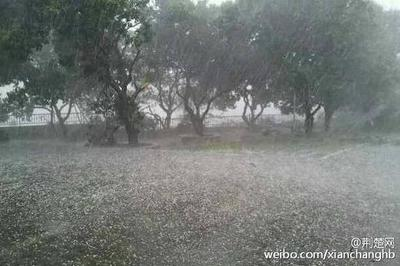

In [9]:
np.array(Image.open(img_paths[0]))

In [10]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0
    return normalized_img

In [11]:
train_dataset = CustomDataset(X_train, y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

In [12]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

# ResNet

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        return x

In [14]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, 1)
            blocks.append(block)
        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [29]:
model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

'cuda'

# DenseNet

In [ ]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2(out_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7, stride=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        for block in self.dense_blocks:
            x = block(x)

        x = self.bn2(x)
        x = self.pool2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model = DenseNet(
    num_blocks=[6, 12, 24, 16],
    growth_rate=32,
    num_classes=n_classes
).to(device)

---


In [25]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_preds = model(X)
            loss = criterion(y_preds, y)
            losses.append(loss.item())
            _, predicted = torch.max(y_preds.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

In [26]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()

        for idx, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_preds = model(X)
            loss = criterion(y_preds, y)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return train_losses, val_losses

In [31]:
lr = 1e-3
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [32]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

Epoch: 1/50 | Train Loss: 2.3151 | Val Loss: 2.2870 | Val Acc: 0.1697
Epoch: 2/50 | Train Loss: 2.1522 | Val Loss: 2.1493 | Val Acc: 0.3350
Epoch: 3/50 | Train Loss: 2.0357 | Val Loss: 2.0336 | Val Acc: 0.3853
Epoch: 4/50 | Train Loss: 1.9377 | Val Loss: 1.9344 | Val Acc: 0.4137
Epoch: 5/50 | Train Loss: 1.8502 | Val Loss: 1.8499 | Val Acc: 0.4246
Epoch: 6/50 | Train Loss: 1.7710 | Val Loss: 1.7793 | Val Acc: 0.4348
Epoch: 7/50 | Train Loss: 1.7027 | Val Loss: 1.7213 | Val Acc: 0.4385
Epoch: 8/50 | Train Loss: 1.6433 | Val Loss: 1.6615 | Val Acc: 0.4552
Epoch: 9/50 | Train Loss: 1.5960 | Val Loss: 1.6147 | Val Acc: 0.4632
Epoch: 10/50 | Train Loss: 1.5484 | Val Loss: 1.5740 | Val Acc: 0.4771
Epoch: 11/50 | Train Loss: 1.5061 | Val Loss: 1.5377 | Val Acc: 0.4836
Epoch: 12/50 | Train Loss: 1.4785 | Val Loss: 1.5086 | Val Acc: 0.5004
Epoch: 13/50 | Train Loss: 1.4370 | Val Loss: 1.4807 | Val Acc: 0.5084
Epoch: 14/50 | Train Loss: 1.4238 | Val Loss: 1.4622 | Val Acc: 0.5106
Epoch: 15/50 | 

In [36]:
type(val_losses)

list

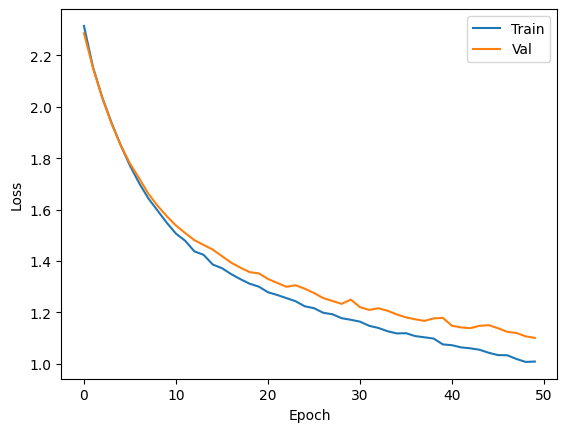

In [37]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [38]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Val Loss: 1.1003 | Val Acc: 0.6286


In [39]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 1.0367 | Test Acc: 0.6419
